# Result comparaison for Superpixels Entropy

In [72]:
import numpy as np
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data

from SSGA import SSGA

In [73]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter

N,M,B = usedDataset["shape"]
N,M,B = usedDataset["data"].shape

def computePs(K):
    gamma = 0.15
    return int(N*M/K * 1/np.log(np.log(N*M/K)) * gamma)

## Finding $\lambda$ coefficient

In [74]:
def find_lambda_coeff(data, K, mini, maxi, similarity_function, Ps, print_info=False):
    def aux(i,j, SP):
        coeff = int((i+j)/2)
        if print_info:
            print("finding lambda coeff:", coeff)
        if i>=j:
            return SP, max(coeff,1)
        
        SP = ERS.find_superpixel(data, K, coeff, similarity_function)
        minSPsize = min([len(l) for l in SP])
        if minSPsize==Ps:
            return SP, coeff
        elif minSPsize<Ps:
            return aux(coeff+1, j, SP)
        else:
            return aux(i, coeff-1, SP)
        
    return aux(mini, maxi, None)

## Compute SPs

In [75]:
RunDataFormat = True

In [76]:
# Comparing data format
if RunDataFormat:
    data1 = usedDataset["data"].copy()
    data2 = Data.normalized_data(usedDataset["data"].copy())
    data3 = Data.standardize_data( usedDataset["data"].copy() )
    datas = [data1, data2, data3]
    names = ["Basic", "Normalized", "Standardized"]
    Ks = [100*i for i in range(1,8)]
    SPsDic = {}

    # Values found with find_lambda_coeff function
    IndianLambdaCoeffDatas = {
        100:[1, 17, 34],
        200:[1, 33, 72],
        300:[1, 52, 110],
        400:[1, 59, 150],
        500:[1, 78, 187],
        600:[1, 94, 230],
        700:[1, 133, 275]
    }
    UniversityLambdaCoeffDatas = {
        100:[1, 17, 42],
        200:[1, 32, 84],
        300:[1, 47, 123],
        400:[1, 60, 166],
        500:[1, 81, 210],
        600:[1, 97, 251],
        700:[1, 111, 300]
    }
    
    for K in Ks:
        print("K:", K)
        Ps = computePs(K)

        current_list = []
        for i,data in enumerate(datas):
            print(i, end=" ")
            #SPs, coeff = find_lambda_coeff(data, K, 1, 350, ERS.complete_basic_similarity, Ps)
            #print("Choosen Coef:", coeff)
            SPs = ERS.find_superpixel(data, K, IndianLambdaCoeffDatas[K][i], ERS.complete_basic_similarity, True)
            current_list.append(SPs)
        print()
        SPsDic[K] = current_list

K: 100
0 1 2 
K: 200
0 1 2 
K: 300
0 1 2 
K: 400
0 1 2 
K: 500
0 1 2 
K: 600
0 1 2 
K: 700
0 1 2 


In [77]:
if not RunDataFormat:
    datas = [ERS.complete_basic_similarity,
                        ERS.complete_norm2_similarity,
                        ERS.complete_norm1_similarity]
    names = ["Basic", "(.)²", "|.|"]

    trainData = Data.standardize_data(usedDataset["data"])
    SPsDic = {}

    # Values found with find_lambda_coeff function
    IndianLambdaCoeffDatas = {
        50: [17, 27, 15],
        100:[34, 58, 31],
        200:[72, 114, 70],
        300:[110, 179, 102],
        400:[150, 242, 141],
        500:[187, 308, 180],
        600:[230, 379, 217]
    }
    UniversityLambdaCoeffDatas = {
        100:[42, 59, 44],
        200:[84, 121, 92],
        300:[123, 185, 140],
        400:[166, 255, 184],
        500:[210, 331, 236],
        600:[251, 404, 280],
        700:[300, 481, 325]
    }
    Ks = list(IndianLambdaCoeffDatas.keys())
    for K in Ks:
        print("K:", K)
        Ps = computePs(K)
        
        current_list = []
        for i,simFun in enumerate(datas):
            print(i, end=" ")
            #SPs, coeff = find_lambda_coeff(trainData, K, 1, 100, simFun, Ps)
            #print("Choosen Coef:", coeff)
            SPs = ERS.find_superpixel(trainData, K, IndianLambdaCoeffDatas[K][i], simFun, True)
            current_list.append(set_matplotlib_close)
        print()
        SPsDic[K] = current_list

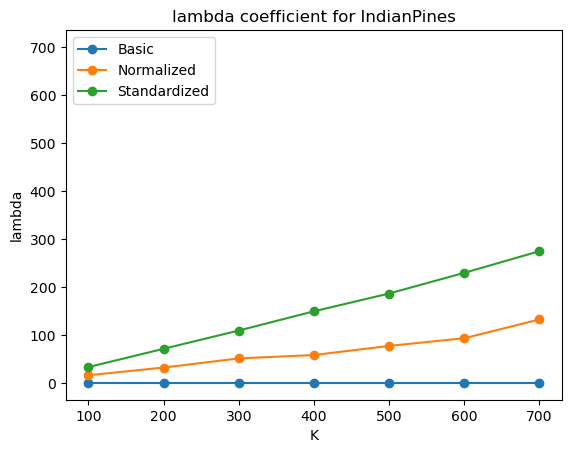

In [78]:
LambdaCoeffs = IndianLambdaCoeffDatas
for i in range(len(datas)):
    plt.plot(Ks, [LambdaCoeffs[K][i] for K in Ks], "-o", label=names[i])

maxi = max(max(Ks), max([LambdaCoeffs[K][i] for K in Ks for i in range(len(datas))]))
plt.plot(maxi,maxi, "")
plt.xlabel("K")
plt.ylabel("lambda")
plt.title("lambda coefficient for IndianPines")
plt.legend()
plt.show()

### Superpixels Classifier

In [79]:
class Superpixel:
    def __init__(self, liste, labels, gt, counting0=True):
        self.labels = [l for l in labels if not(not counting0 and l==0)]
        self.pixels = [coor for coor in liste if not(not counting0 and gt[coor]==0)]

        self.class_count = {l:0 for l in self.labels}
        for coor in self.pixels:
            self.class_count[gt[coor]] += 1

        self.guess = self.labels[0]
        for l in self.labels:
            if self.class_count[l] > self.class_count[self.guess]:
                self.guess = l

        self.proportion = self.class_count[self.guess]/len(self.pixels)
        self.isSingleClass = self.class_count[self.guess] == len(self.pixels)




class SuperpixelClassifier:
    def __init__(self, liste, labels, gt, counting0=True):
        self.labels = [l for l in labels if not(not counting0 and l==0)]

        self.liste = []
        self.pixels = []
        for l in liste:
            new_list = [coor for coor in l if not(not counting0 and gt[coor]==0)]
            if new_list!=[]:
                self.liste.append(new_list)
                self.pixels += new_list

        self.SPs:list[Superpixel] = [Superpixel(l, self.labels, gt, counting0) for l in self.liste]
        self.association:dict[tuple[int,int], Superpixel] = {}
        for i,SP in enumerate(self.SPs):
            for coor in SP.pixels:
                self.association[coor] = i

        self.data_class = {l:[] for l in labels}
        self.guess_map = np.zeros(gt.shape, dtype=int)
        for x,y in self.pixels:
            g = self.guess(x,y)
            self.guess_map[x,y] = g
            self.data_class[g].append((x,y))

    
    def getSP(self, x,y) -> Superpixel:
        return self.SPs[self.association[(x,y)]]
    

    def guess(self, x,y):
        return self.getSP(x,y).guess


    def predict(self, liste):
        return [self.guess(x,y) for x,y in liste]
    
    
    def accuracy(self, samples, labels):
        assert len(samples)==len(labels)
        prediction = self.predict(samples)
        return len([i for i in range(len(samples)) if prediction[i]==labels[i]])
    

    def singleClassCount(self):
        return len([i for i in range(len(self.SPs)) if self.SPs[i].isSingleClass])
    

    def averageProportion(self):
        return np.average([SP.proportion for SP in self.SPs])

    
    def overallAccuracy(self, gt):
        goodGuessCount = 0
        for x,y in self.pixels:
            if gt[x,y] == self.guessMap[x,y]:
                goodGuessCount +=1
        return goodGuessCount/len(self.pixels)
    

    def averageAccuracy(self, gt, labels):
        dic = {l:[0,0] for l in labels}
        for x,y in self.pixels:
            l = gt[x,y]
            dic[l][0] += 1
            if l==self.guess(x,y):
                dic[l][1] += 1

        return sum([e[1]/e[0] for l,e in dic.items()])/len(labels)
    
    
    def averageJaccard(self, gt, data_class):
        sum = 0
        for l in self.data_class.keys():
            inter = len(set(data_class[l]).intersection(self.dataClass[l]))
            union = len(set(data_class[l]).union(self.dataClass[l]))
            sum += inter/union
        return sum/len(self.labels)


In [81]:
ClassifierDic:dict[int, list[SuperpixelClassifier]] = {}

for b in [True, False]:
    ClassifierDic[b] = {}
    for K in Ks:
        ClassifierDic[b][K] = [
            SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
                    for SPs in SPsDic[K]
            ]

### Visual result

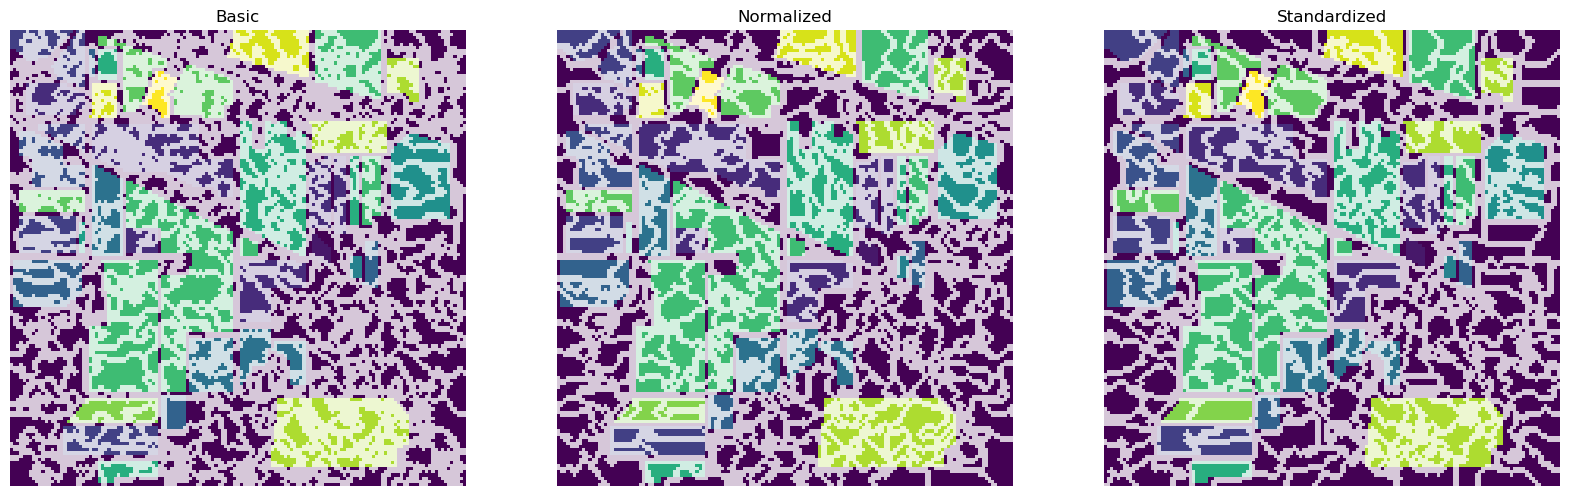

True


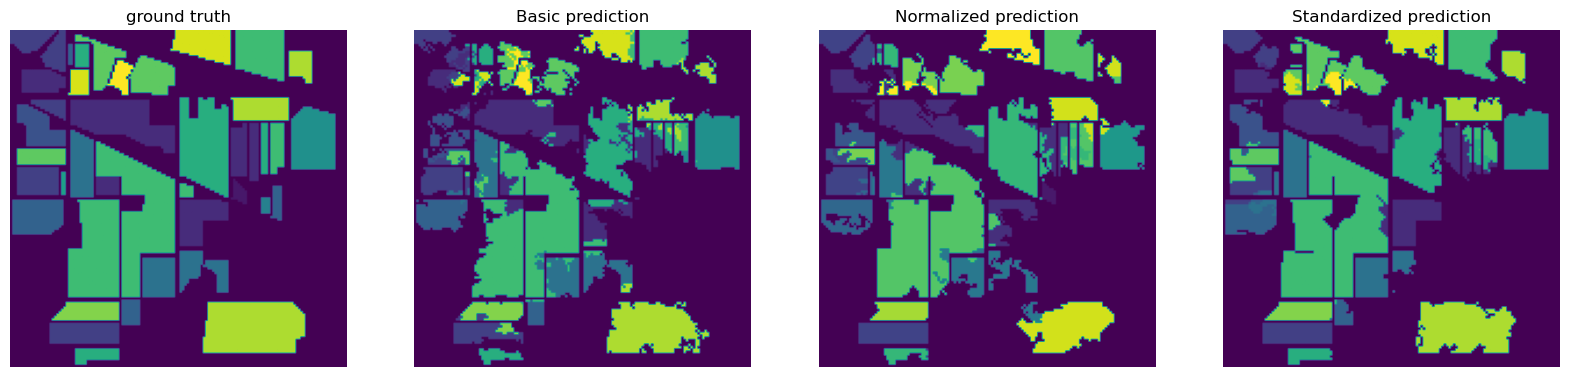

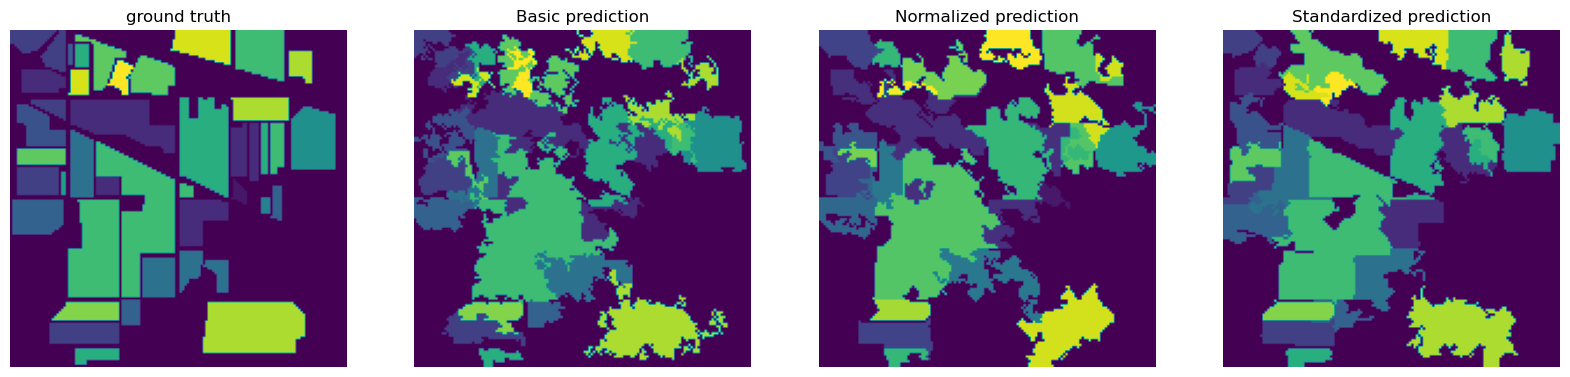

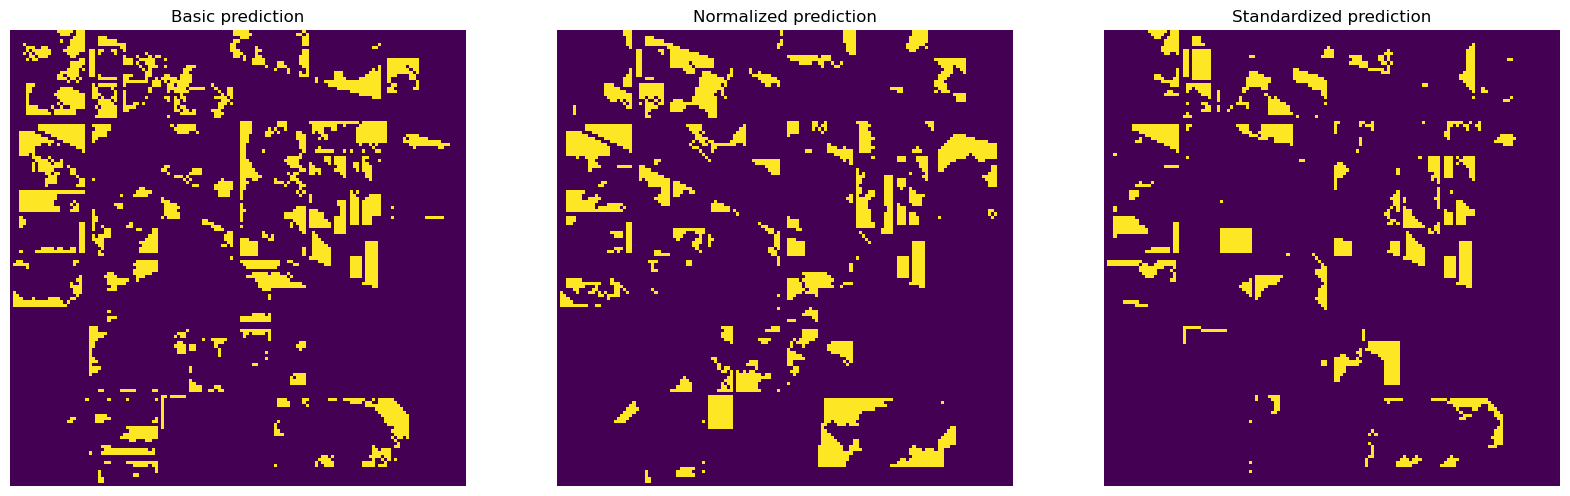

False


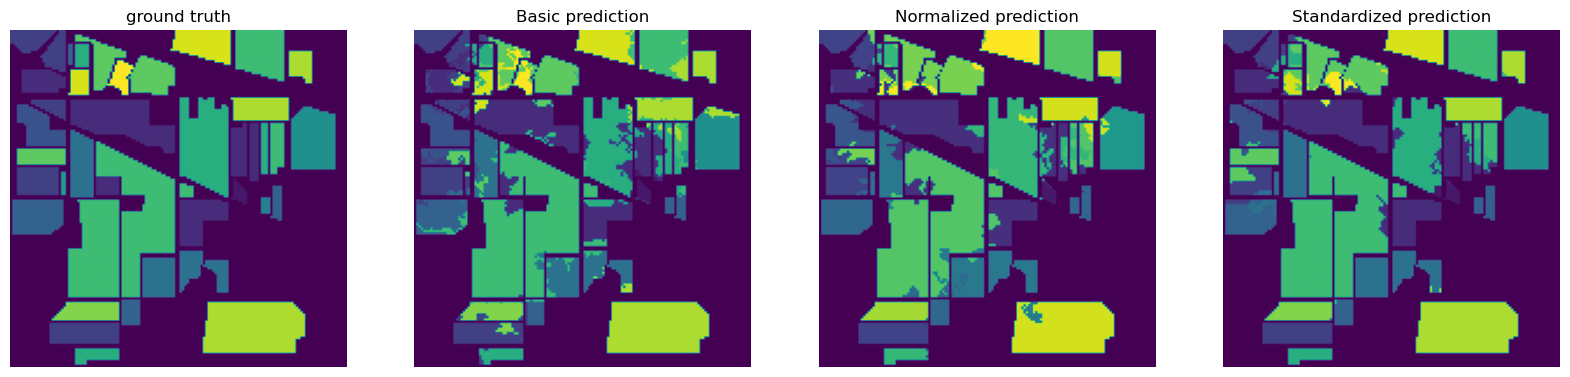

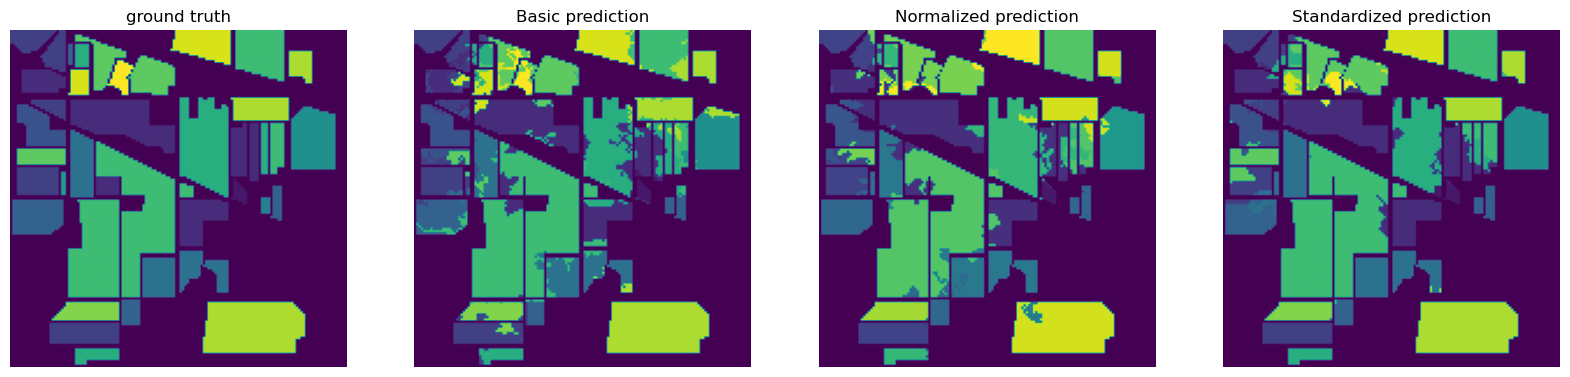

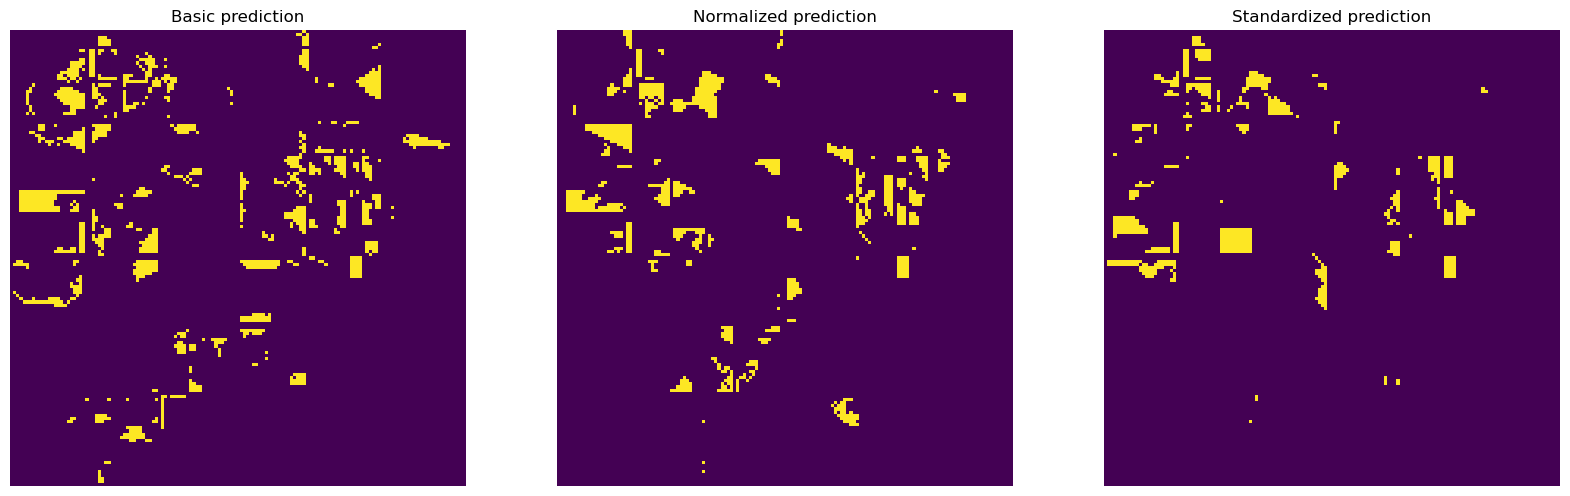

In [82]:
K =  200

fig, axs = plt.subplots(1, len(SPsDic[K]))
fig.set_size_inches(20,30)
for i,SP in enumerate(SPsDic[K]):
    axs[i].imshow(usedDataset["gt"])
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], SP, color=[255,255,255,200]))
    axs[i].title.set_text(names[i])
    axs[i].axis("off")
plt.show()



for b in [True, False]:
    print(b)
    classifiers = ClassifierDic[b][K]

    imgs = [usedDataset["gt"]] + [C.guess_map for C in classifiers]
    titles = ["ground truth"] + [name+" prediction" for name in names]


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]==0:
                    new_img[x,y] = 0
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        axs[i].imshow(imgs[i])
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=0 and usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1
        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()


### Classification result

In [18]:
size = len(ClassifierDic[Ks[0]])
overallAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageJaccard = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
singleClassCounts = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageProportions = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}

for b in [True, False]:
    print(b)
    for K in Ks:
        for i,C in enumerate(ClassifierDic[K]):
            overallAccuracys[b][K][i] = C.overallAccuracy(usedDataset["gt"], b)
            averageAccuracys[b][K][i] = C.averageAccuracy(usedDataset["gt"], usedDataset["labels"], b)
            averageJaccard[b][K][i] = C.averageJaccard(usedDataset["gt"], usedDataset["class"], b)
            singleClassCounts[b][K][i] = C.singleClassCount(b)
            averageProportions[b][K][i] = C.averageProportion(b)
        

True


TypeError: unhashable type: 'list'

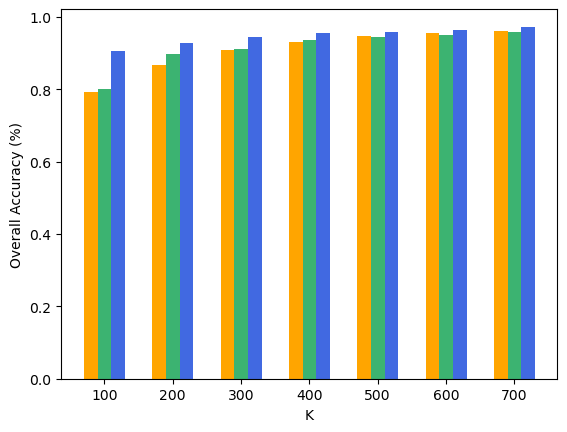

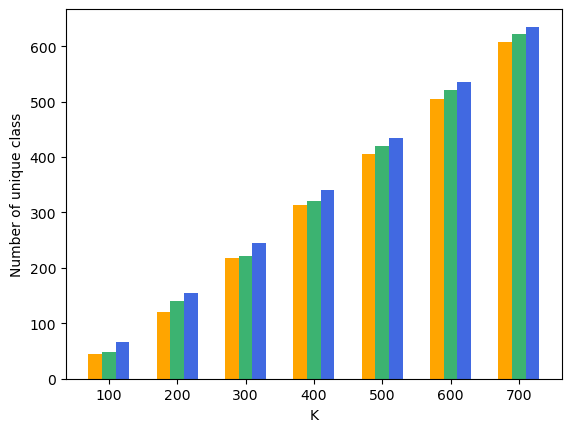

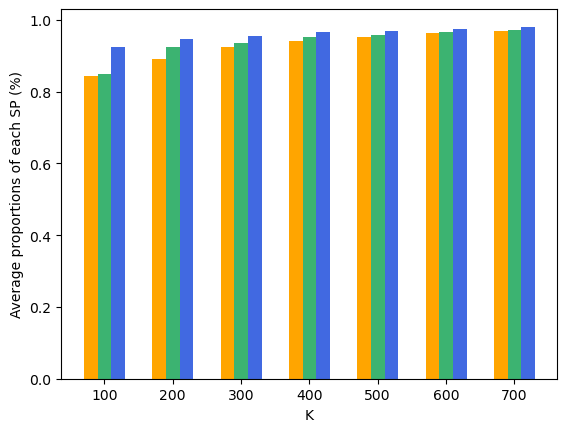

In [ ]:
colors = ["orange", "mediumseagreen", "royalblue"]
def plot_info(info, ylabel=""):
    for k,K in enumerate(Ks):
        if K!=50:
            for d in range(size):
                plt.bar(K+ d*20 -20, info[K][d], color=colors[d], width=20)
    plt.xlabel("K")
    plt.ylabel(ylabel)
    plt.show()

plot_info(overallAccuracys, "Overall Accuracy (%)")
plot_info(singleClassCounts, "Number of unique class")
plot_info(averageProportions, "Average proportions of each SP (%)")

### GA result

In [ ]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1


best_fitness = {K:[0 for _ in range(len(datas))] for K in Ks}

A = 1
for K in Ks:
    print("K:", K)
    for i in range(len(datas)):
        for _ in range(A):
            SPs = SPsDic[K][i]
            pop, fitness = SSGA(data, 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2, False, SP=SPs)
            best_fitness[K][i] += fitness[0]
        best_fitness[K][i] /= A

K: 100
K: 200
K: 300
K: 400
K: 500
K: 600
K: 700


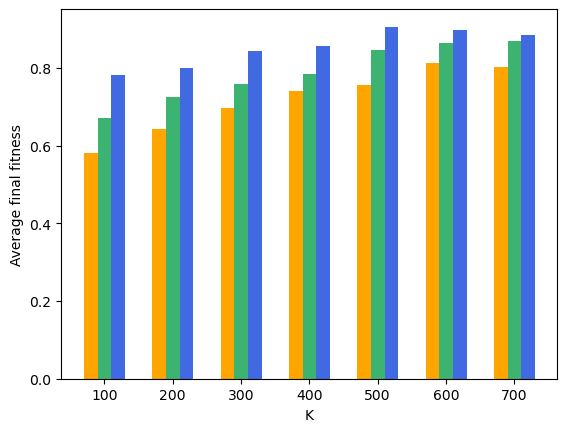

In [ ]:
plot_info(best_fitness, "Average final fitness")